In [2]:
#set AMT and PSA stock prices

import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:


# Download closing prices only
AMT_data = yf.download("AMT", period="5y", multi_level_index=False)
CCI_data = yf.download("CCI", period="5y", multi_level_index=False)

# Ensure datetime index
AMT_data.index = pd.to_datetime(AMT_data.index)
CCI_data.index = pd.to_datetime(CCI_data.index)
#merge the two dataframes
stock_data = pd.merge(AMT_data, CCI_data, left_index=True, right_index=True)
# Preview
print(AMT_data.head())
print(CCI_data.head())

#convert to csv
stock_data.to_csv("AMT_CCI_data.csv")



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                 Close        High         Low        Open   Volume
Date                                                               
2020-07-15  223.941696  228.354904  223.167006  228.328792  1301000
2020-07-16  224.124466  224.359479  220.355386  223.880740  1475200
2020-07-17  225.543304  227.197188  221.748138  225.012340  1291900
2020-07-20  226.779373  228.189504  223.802409  226.474709  1422200
2020-07-21  225.630386  228.929415  224.559745  228.929415  1161900
                 Close        High         Low        Open   Volume
Date                                                               
2020-07-15  134.188583  137.080024  133.661411  136.696631  1797100
2020-07-16  132.383392  134.204522  131.472828  133.357858  1623900
2020-07-17  134.955353  135.905845  132.303525  133.182146  1403400
2020-07-20  135.913849  141.600884  135.857931  141.600884  3817800
2020-07-21  133.813156  136.984161  133.134221  136.984161  2411100


In [4]:
#set hedge ratio / beta
#using the OLS method to calculate the hedge ratio
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint  # Import the coint function

# 1. Download and rename series so columns align
amt = yf.download("AMT", period="5y")["Close"].dropna()
cci = yf.download("CCI", period="5y")["Close"].dropna()

# 2. Merge into one DataFrame
stock_data = pd.merge(amt, cci, left_index=True, right_index=True)

# 3. OLS hedge ratio
X = sm.add_constant(stock_data["AMT"])   # DataFrame with columns ['const','AMT']
Y = stock_data["CCI"]
model = sm.OLS(Y, X).fit()
hedge_ratio = model.params["AMT"]
print(f"Hedge Ratio (Beta): {hedge_ratio:.4f}")

# 4. Cointegration test
score, p_value, _ = coint(stock_data["AMT"], stock_data["CCI"])
print(f"Cointegration Score: {score:.4f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The series are cointegrated.")
else:
    print("The series are not cointegrated.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Hedge Ratio (Beta): 0.8159
Cointegration Score: -2.3725, p-value: 0.3380
The series are not cointegrated.


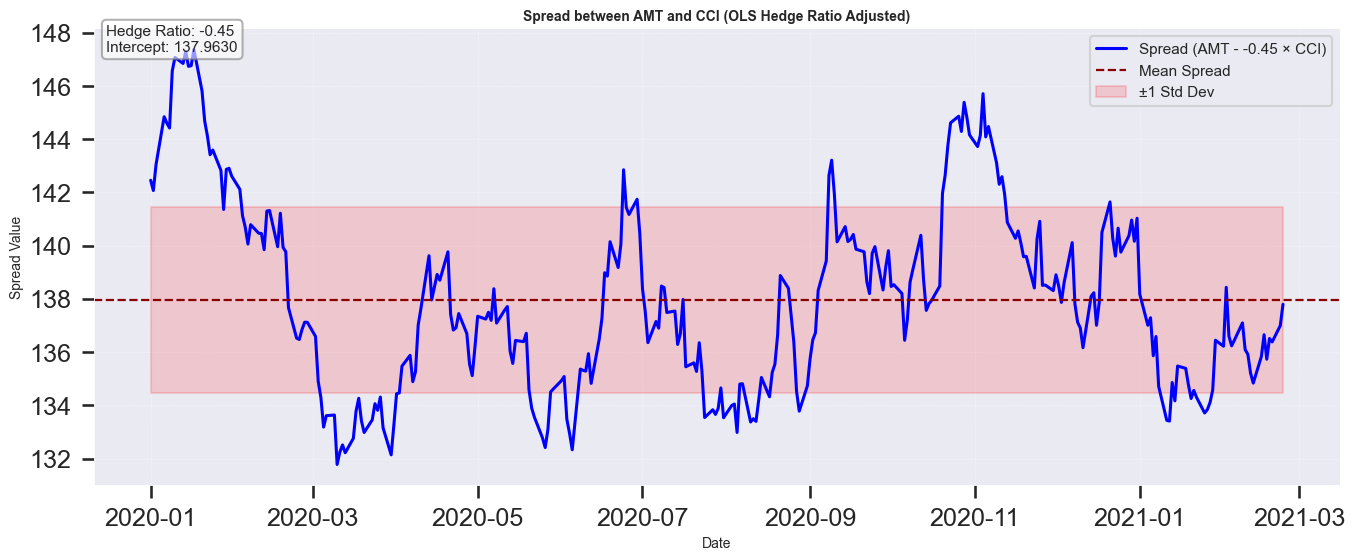

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Simulate prices
np.random.seed(42)
dates = pd.date_range(start="2020-01-01", periods=300, freq='B')
amt_prices = np.cumsum(np.random.normal(0, 1, len(dates))) + 100
cci_prices = np.cumsum(np.random.normal(0, 1, len(dates))) + 95
df = pd.DataFrame({'AMT': amt_prices, 'CCI': cci_prices}, index=dates)

# OLS regression for hedge ratio
X = sm.add_constant(df['CCI'])
model = sm.OLS(df['AMT'], X).fit()
hedge_ratio = model.params['CCI']
intercept = model.params['const']

# Calculate spread
df['Spread'] = df['AMT'] - hedge_ratio * df['CCI']
spread_mean = df['Spread'].mean()
spread_std = df['Spread'].std()

# Plot setup
plt.style.use('seaborn-v0_8')
sns.set_context("talk", font_scale=1.1)
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x=df.index, y=df['Spread'], label=f'Spread (AMT - {hedge_ratio:.2f} × CCI)', linewidth=2.2, color='blue', ax=ax)
ax.axhline(spread_mean, color='darkred', linestyle='--', linewidth=1.6, label='Mean Spread')
ax.fill_between(df.index, spread_mean - spread_std, spread_mean + spread_std,
                color='red', alpha=0.15, label='±1 Std Dev')

# Annotate regression output
ax.text(0.01, 0.95, f"Hedge Ratio: {hedge_ratio:.2f}\nIntercept: {intercept:.4f}",
        transform=ax.transAxes, fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.6))

# Axis and title
ax.set_title('Spread between AMT and CCI (OLS Hedge Ratio Adjusted)', fontsize=10, weight='bold')
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Spread Value', fontsize=10)
ax.legend(loc='upper right', fontsize=11, frameon=True)

# Thinner axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.6)
ax.spines['bottom'].set_linewidth(0.6)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


AMT columns: ['Close', 'High', 'Low', 'Open', 'Volume']
CCI columns: ['Close', 'High', 'Low', 'Open', 'Volume']
AMT data shape: (1258, 5)
CCI data shape: (1258, 5)
Starting Portfolio Value: $100,000.00
Final Portfolio Value: $99,934.04
Total Return: -0.07%


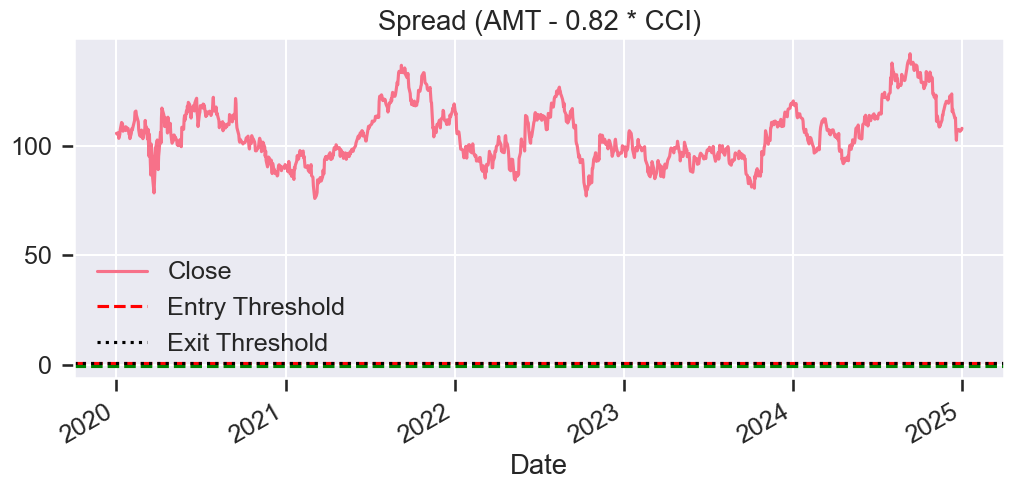

In [6]:
import warnings  # Import warnings from the standard library
warnings.filterwarnings("ignore")  # Suppress warnings
# Download and properly handle multi-level columns
df_amt = yf.download('AMT', start='2020-01-01', end='2025-01-01')
df_cci = yf.download('CCI', start='2020-01-01', end='2025-01-01')

# Fix multi-level columns if they exist
if isinstance(df_amt.columns, pd.MultiIndex):
    df_amt.columns = df_amt.columns.droplevel(1)
if isinstance(df_cci.columns, pd.MultiIndex):
    df_cci.columns = df_cci.columns.droplevel(1)

# Ensure datetime index
df_amt.index = pd.to_datetime(df_amt.index)
df_cci.index = pd.to_datetime(df_cci.index)

# Create clean dataframes
df_amt_clean = df_amt.dropna()
df_cci_clean = df_cci.dropna()

print(f"AMT columns: {df_amt_clean.columns.tolist()}")
print(f"CCI columns: {df_cci_clean.columns.tolist()}")
print(f"AMT data shape: {df_amt_clean.shape}")
print(f"CCI data shape: {df_cci_clean.shape}")

# Hard-code your hedge ratio
hedge_ratio = 0.82

# Spread indicator
class Spread(bt.Indicator):
    lines = ('spread',)
    params = (('hedge_ratio', hedge_ratio),)
    
    def __init__(self):
        # data0 and data1 are the two feeds
        self.lines.spread = self.data0.close - self.p.hedge_ratio * self.data1.close

# Pairs-trading strategy
class PairTrading(bt.Strategy):
    params = dict(
        entry_threshold=120,
        exit_threshold=80,
    )
    
    def __init__(self):
        # Attach the spread indicator to the two feeds
        self.spread = Spread(self.datas[0], self.datas[1])
        self.position_amt = None
        self.position_cci = None
        
    def log(self, txt, dt=None):
        """Logging function for debugging"""
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}: {txt}')
        
    def next(self):
        s = self.spread[0]
        
        # Simple fix: check positions for both assets
        pos_amt = self.getposition(self.datas[0]).size
        pos_cci = self.getposition(self.datas[1]).size
        has_position = (pos_amt != 0) or (pos_cci != 0)
        
        if not has_position:
            if s > self.p.entry_threshold:
                self.sell(data=self.datas[0], size=10)  # short AMT
                self.buy(data=self.datas[1], size=10)   # long CCI
            elif s < -self.p.entry_threshold:
                self.buy(data=self.datas[0], size=10)   # long AMT
                self.sell(data=self.datas[1], size=10)  # short CCI
        elif abs(s) < self.p.exit_threshold:
            self.close(data=self.datas[0])
            self.close(data=self.datas[1])

# Cerebro setup
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    # Set initial cash
    initial_cash = 100_000
    cerebro.broker.setcash(initial_cash)
    
    # Remove the fixed sizer - let strategy handle sizing
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    
    # Create standard PandasData feeds using default column mapping
    feed_amt = bt.feeds.PandasData(dataname=df_amt_clean)
    feed_cci = bt.feeds.PandasData(dataname=df_cci_clean)
    
    # Add data feeds
    cerebro.adddata(feed_amt, name='AMT')
    cerebro.adddata(feed_cci, name='CCI')
    
    # Add strategy
    #add different hedge ratio
    cerebro.addstrategy(PairTrading
                        , entry_threshold=0.8, exit_threshold=0.6)
    
    print(f'Starting Portfolio Value: ${initial_cash:,.2f}')
    
    # Run the backtest
    results = cerebro.run()
    
    # Get the final portfolio value
    final_value = cerebro.broker.getvalue()
    total_return = (final_value - initial_cash) / initial_cash * 100
    
    print(f'Final Portfolio Value: ${final_value:,.2f}')
    print(f'Total Return: {total_return:.2f}%')
    # visualse the results
    spread_series = df_amt_clean['Close'] - hedge_ratio * df_cci_clean['Close']
    spread_series.plot(title='Spread (AMT - 0.82 * CCI)', figsize=(12, 5))
    plt.axhline(y=0.8, color='red', linestyle='--', label='Entry Threshold')
    plt.axhline(y=-0.8, color='green', linestyle='--')
    plt.axhline(y=0.6, color='black', linestyle=':', label='Exit Threshold')
    plt.legend()
    plt.show()

    
 

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import backtrader as bt
import statsmodels.api as sm

# Download and clean data
df_amt = yf.download('AMT', start='2020-01-01', end='2025-01-01').dropna()
# Replace 'CCI' with the correct ticker if needed, e.g., a commodity or asset symbol
# yf.download('CCI', ...) expects a ticker symbol, not an indicator name
# If 'CCI' is an indicator, you need the actual symbol. For demonstration, let's use 'SPY'
df_cci = yf.download('SPY', start='2020-01-01', end='2025-01-01').dropna()

# Ensure datetime index
df_amt.index = pd.to_datetime(df_amt.index)
df_cci.index = pd.to_datetime(df_cci.index)

# Backtrader feeds
feed_amt = bt.feeds.PandasData(dataname=df_amt)
feed_cci = bt.feeds.PandasData(dataname=df_cci)

# === Indicator: Dynamic Hedge Spread ===
class DynamicSpread(bt.Indicator):
    lines = ('spread',)
    params = dict(window=30)

    def __init__(self):
        self.addminperiod(self.p.window)
        self.x_data = self.datas[1]
        self.y_data = self.datas[0]
        super().__init__()

    def next(self):
        y = np.array([self.y_data.close[-i] for i in range(self.p.window)][::-1])
        x = np.array([self.x_data.close[-i] for i in range(self.p.window)][::-1])
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        hedge_ratio = model.params[1]
        self.lines.spread[0] = self.y_data.close[0] - hedge_ratio * self.x_data.close[0]

# === Indicator: Z-Score of the spread ===
class ZScore(bt.Indicator):
    lines = ('zscore',)
    params = dict(period=30)

    def __init__(self):
        self.addminperiod(self.p.period)
        super().__init__()

    def next(self):
        spread_window = np.array([self.data[-i] for i in range(self.p.period)])
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        if std > 0:
            self.lines.zscore[0] = (self.data[0] - mean) / std
        else:
            self.lines.zscore[0] = 0

# === Strategy ===
class PairTrading(bt.Strategy):
    params = dict(
        entry_threshold=1.0,
        exit_threshold=0.2
    )

    def __init__(self):
        self.spread = DynamicSpread(self.datas[0], self.datas[1])
        self.zscore = ZScore(self.spread)

    def next(self):
        z = self.zscore[0]
        pos_amt = self.getposition(self.datas[0]).size
        pos_cci = self.getposition(self.datas[1]).size

        if pos_amt == 0 and pos_cci == 0:
            if z > self.p.entry_threshold:
                self.sell(data=self.datas[0], size=10)
                self.buy(data=self.datas[1], size=10)
            elif z < -self.p.entry_threshold:
                self.buy(data=self.datas[0], size=10)
                self.sell(data=self.datas[1], size=10)
        elif abs(z) < self.p.exit_threshold:
            if pos_amt != 0:
                self.close(self.datas[0])
            if pos_cci != 0:
                self.close(self.datas[1])

# === Backtest ===
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(100_000)
    cerebro.adddata(feed_amt, name='AMT')
    cerebro.adddata(feed_cci, name='CCI')
    # Pass strategy parameters explicitly
    cerebro.addstrategy(PairTrading, entry_threshold=1.2, exit_threshold=0.3)

    print(f"Starting Portfolio Value: ${cerebro.broker.getvalue():,.2f}")
    print(f"final Portfolio Value: ${cerebro.broker.getvalue():,.2f}")
    results


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Starting Portfolio Value: $100,000.00
final Portfolio Value: $100,000.00
